In [2]:
import math

import matplotlib.pyplot as plt
import scipy.optimize as sopt
import numpy as np
import pandas as pd

In [2]:
path_to_data = 'data/adv/TDRK/'

In [3]:
import sympy as sp
x, τ, u, u_s, A, ω, α, β, x_lab = sp.symbols("x, τ, u, u_s, A, ω, α, β, x_lab")
sp.init_printing()

In [2]:
%texify

UsageError: Line magic function `%texify` not found.


<img src="mephi_logo.png" style="display: block; position: absolute; top: -25px; left: 0; width: 15%;" />

<img src="logo.jpg" style="float: left; display: block; width: 24%; padding: 5px;" />


<h2 style="font-size: x-large;">Численное моделирование регуляризации колебаний слабо нелинейных одномерных детонационных волн методами высокого порядка</h2>


---
*Белолуцкий Фёдор Алексеевич, студент группы Б19-221 НИЯУ МИФИ*


*Научный руководитель: Касимов Аслан Рамазанович, Ph.D., доцент Сколтеха*


<span style="font-size: smaller;">При поддержке гранта РФФИ № 20-51-00004.</span>

<div style="position: fixed; border-top: thick double black; border-bottom: thick double black; top: 0; right: 0;">
    
<div style="text-align: center; margin: 0 auto; font-size: smaller;">IX Международная конференция «Лазерные, плазменные исследования и технологии» ЛаПлаз-2023», 28&ndash;31 марта 2023 года, НИЯУ МИФИ,  Москва</div></div>


<style>p, figcaption, li, em{/*text-align: justify;*/ font-size: 0.9em;}</style>
<style>
    .numbering {
        display: block;
        position: absolute;
        bottom: 0;
        right: 0;
    }
</style>

## Упрощённая математическая модель. Реактивное уравнение Бюргерса



Для случая неоднородных граничных условий в системе отсчёта детонационной волны *(Kasimov & Gonchar. Proc. Combust. Inst. (2020) <a href="https://www.sciencedirect.com/science/article/abs/pii/S1540748920306404">doi:10.1016/j.proci.2020.07.149</a>)*:

$$ \forall x \leqslant 0 \quad \forall t > 0 \quad 
\boxed{\partial_{t}u\left(x,t\right)+\partial_{x}F\left[u\left(x,t\right),u\left(x=x_{s},t\right)\right]=S\left[x;u\left(x=x_{s},t\right)\right]},
$$  <!-- _{\text{KFR}} -->
где поток имеет вид $ \frac{1}{2}\left(u\left(x,t\right)\right)^2 - D_s u\left(x,t\right) $,

источниковый член определяется функцией (с параметрами $ \alpha \geqslant 0 $, $ \beta > 0 $, $ k > 0 $)

$$ \left(x,t\right) \stackrel{S[\dots]}{\mapsto} \frac{q}{2} \cdot \frac{1}{\sqrt{2\pi}\sqrt{2\beta}}\exp\left(-\frac{1}{2}\cdot\frac{\left(x-\xi_{s}\left[u\left(x_{s},t\right)\right]\right)^{2}}{\left(\sqrt{2\beta}\right)^{2}}\right), $$  <!-- _\text{KFR} -->

$$\qquad t\mapsto\xi_{s}\left[u\left(x_{s},t\right)\right]\stackrel{\text{def}}{:=}t\mapsto-k\left(\frac{u_{0}\left(x_{s}\right)}{u\left(x_{s},t\right)}\right)^{\alpha}.$$
Скорость распространения детонационной волны: $ D_s \equiv \frac{dx_s}{dt} = \frac{1}{2}\left(u\left(x_s, t\right)+u\left(x_a, t\right)\right). $

А стационарное решение $ u_0 $: <!-- x\stackrel{}{\mapsto}\frac{u_{0}\left(x_{s}\right)+u_{0}\left(x_{a}\right)}{2} -->
$ u_{0}\stackrel{\text{def}}{:=} D_s + \sqrt{2\int_{-\infty}^{x}S\left[y,u_{0}\left(x_{s}\right)\right]dy} $.

$$ u_{0}\left(x_{s}\right)=u_{0}\left(x_{a}\right)+2\sqrt{2\int_{-\infty}^{0}S\left[y,u_{0}\left(x_{s}\right)\right]dy} $$  <!-- _{\text{KFR}} -->

## Постановка задачи

$$
\partial_{t}u\left(x,t\right)+\partial_{x}[0.5\left(u\left(x,t\right)\right)^2 - D_s u\left(x,t\right)]=$$
$$=\frac{\frac{1}{2}q}{\sqrt{4\pi\beta}}\exp\left(\frac{-\left(x+k\left(\frac{u_{0}\left(x_{s}\right)}{u\left(x_{s},t\right)}\right)^{\alpha}\right)^{2}}{2\left(\sqrt{2\beta}\right)^{2}}\right)
$$

$$\frac{dx_s}{dt} = 0.5\left(u_s\left(t\right)+u_a\left(t\right)\right)$$
$$ u_a(x_{\text{lab}}) = \bar{u}_a \left( 1 + \sin \left(kx_{\text{lab}}\right) \right) $$


<figure style="text-align: center;"><img style="text-align: center; margin: 0 auto;" src="profile_sketch_broad_and_low.svg" alt="Wave in a non-uniform medium solution profile sketch"/>
    <figcaption style="text-align: center; margin: 0 auto; ">Рис. 1: Схема профиля решения для случая неоднородной гармонически меняющейся среды перед детонационной волной</figcaption>
</figure>


<!-- <div class="numbering">3/1</div> -->

## Упрощённое описание слабо нелинейной детонации в невязком пределе

<p style="text-align: justify;">Уравнения Эйлера, откуда, можно сказать, в пределе получается модель:</p>
$$\partial_t \rho + \partial_x \left[ \rho \left(u-D_s\right) \right] = 0$$
$$\partial_t \left[\rho u\right] + \partial_x \left[ \rho u \left(u-D_s\right) + p \right] = 0$$
$$\partial_t \left[\rho E\right] + \partial_x \left[ \rho E \left(u-D_s\right) + p u \right] = 0$$
$$\partial_t \left[\rho \lambda \right] + \partial_x \left[ \rho \lambda \left(u-D_s\right) + p u \right] = \rho \omega$$
$$\omega = k (1-\lambda) \exp \left(-\frac{\rho E_a}{p}\right) $$

<hr/>

$$ \substack{\partial_t u + \frac{1}{2} \partial_x \left[ u^2 +q\lambda \right] =  0, \\ \partial_t \lambda = \omega \left(\lambda, u\right)} \qquad \rightarrow \qquad \substack{\partial_\tau u + \frac{1}{2} \partial_\xi u^2 = q \partial_\xi \lambda, \\ \partial_\xi \lambda = \omega \left(\lambda, u\right)} $$

<p style="text-align: center; margin: 0 auto;">Разделение масштабов в слабо нелинейном пределе</p>
<p style="text-align: center; margin: 0 auto;">(поток до ударной волны почти звуковой в сравнении с ней)</p>

<p style="text-align: justify;">Рассматриваем одностадийную необратимую хим. реакцию по закону Аррениуса. В нашей модели аналогом энергии активации является параметр $ \alpha $.</p>

## Обезразмеренная версия реактивного уравнения Бюргерса

<p style="text-align: justify;">Обозначим: $ \nu_s \stackrel{\text{def}}{:=} \left[u_0(0)\right] = (u_0(x_s)-u_0(x_a))$. Перенормировки: $u_* \stackrel{\text{def}}{:=} \frac{u}{\nu_s}$, $L_* \stackrel{\text{def}}{:=} \frac{L}{k}$, $t_* \stackrel{\text{def}}{:=} \frac{t}{k/\nu_s} $.</p>

<p style="text-align: justify;">Введём параметр $A$: $u_{a*} = A u_{0*}\left(x_{s*}\right)$. $ u_a(x) = \frac{A}{1-A} \left( 1 + \sin \left(kx\right) \right) $</p>


<p  style="text-align: justify;">Стационарное решение:</p>
$$ u_{0*}(x_*) = \frac{ A }{ 1 - A } + \frac{1}{2} \left( 1 + \sqrt{\frac{1+\text{erf}\frac{x_*+1}{2\sqrt{\beta}}}{1+\text{erf}\frac{1}{2\sqrt{\beta}}}} \right). $$


<p  style="text-align: justify;">Источниковый член для реактивного уравнения Бюргерса:</p>
$$ S_{*}\left[x_*, u_{*}\left(x_{s*}, t_*\right)\right] = \left( 4  \sqrt{2\pi} \sqrt{2\beta_*} \left( 1+\text{erf}\left(\frac{1}{\sqrt{4\beta_*}}\right) \right) \right)^{-1} \exp \left({ - \frac{1}{2} \frac{\left( x_* - \xi_{s*} \right)^2}{\left( \sqrt{2\beta_*} \right)^2} }\right). $$


<!-- <div class="numbering">4</div> -->

## Стационарное решение

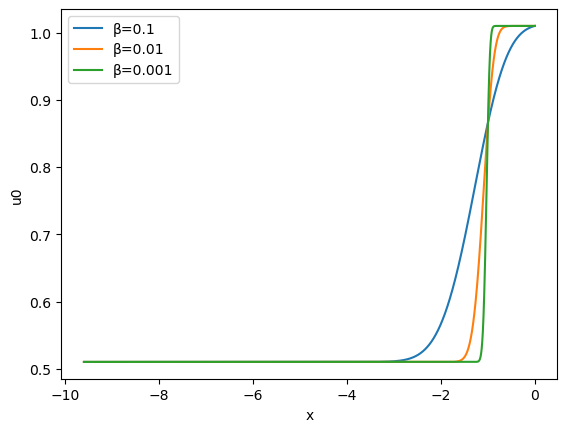

In [32]:
def kfrSteadyStateSol(x, amp, beta, epsilon=1e-6):
    var1 = 1. + math.erf((x + 1.) / np.sqrt(4. * beta))
    var2 = 1. + math.erf((0. + 1.) / np.sqrt(4. * beta))

    u0 = (amp / (1. - amp)
          + 0.5 * (1. + np.sqrt(var1 / var2)) + epsilon * np.sin(x))

    return u0


x = np.linspace(-10+0.4, 0, 20000)
plt.plot(x, [kfrSteadyStateSol(v, 0.01, 0.1) for v in x], label='β=0.1')
plt.plot(x, [kfrSteadyStateSol(v, 0.01, 0.01) for v in x], label='β=0.01')
plt.plot(x, [kfrSteadyStateSol(v, 0.01, 0.001) for v in x], label='β=0.001')
plt.legend()
plt.xlabel('x')
plt.ylabel('u0')
plt.savefig('beta.svg', format='svg', transparent=True)
plt.show()

<figure style="text-align: center; margin: 0 auto;"><img style="text-align: center; margin: 0 auto;" src="beta.svg" alt="бегущая волна"/>
    <figcaption style="text-align: center; margin: 0 auto;">Рис. 2: Стационарные решения при разных $ \beta $, аналога длины зоны тепловыделения</figcaption>
</figure>



<!-- <div class="numbering">4/1</div> -->

## Актуальность и цель проводящейся работы


<p style="text-align: justify;">Существенно <b>нелинейный</b> характер детонации $ \rightarrow $ возможность <b>регуляризации её колебаний</b> через <b>синхронизацию</b> (в данном случае с периодическим изменением среды перед волной). Такое упрощение и контроль детонации представляют большой интерес.</p>

<p style="text-align: justify;">Основная вычислительная задача в изучении подобных процессов: эффективное получение <strong>разрывных</strong> и высокоградиентных решений <strong>со сложной нелинейной структурой</strong>, что предполагает использование высокоточных методов, <strong>методов высокого порядка</strong>.</p>

<p style="text-align: justify;"><span style="font-style: italic;">Итоговая цель работы:</span> детальное рассмотрение динамики одномерной волны детонации (временного развития изначально стационарного решения, возмущённого численным шумом) в газовой смеси с периодически меняющимися в пространстве свойствами и составления «карты» спектральных свойств детонации для области параметрического пространства гармонически изменяющегося состояния среды перед ударной волной с помощью методов высокого порядка для наиболее простой модели.</p>

<!--<p style="text-align: justify;"><span style="font-style: italic;">Рассматриваемые методы:</span> для интегрирования итогового временного ОДУ метода прямых eBDF5, ERK(6, 5), SSP-ERK(3, 3), SSP-ERK(10, 4), SSP-TS-ERK(12, 8), конечно-разностные схемы с LF-потоком и WENO-реконструкцией разных порядков и модификаций: WENO5-JS, WENO5-(F)M, WENO5-(F)IM, WENO7-BS, WENO7-(F)M, WENO7-S(M), WENO9-BS, WENO9-S(M), WENO11-S(M)</p>-->

<figure style="text-align: center;"><img style="text-align: center; margin: 0 auto;" src="wavelets_surf.svg" alt="Wave in a non-uniform medium solution profile sketch"/>
    <figcaption style="text-align: center; margin: 0 auto; ">Рис. 3: Иллюстративный пример синхронизации детонации с гармоническим изменением параметров среды перед головной ударной волной</figcaption>
</figure>

<!-- <p>Ключевые слова: ERK(6, 5), SSP-ERK(3, 3), WENO-схемы, WENO5, WENO5-FM, WENO7, WENO7-FM, детонации, метод прямых, методы Рунге-Кутты, нелинейная динамика, нелинейные схемы, регуляризация детонационных волн, синхронизация, суперкомпьютерное моделирование, существенно не осциллирующие схемы и их модификации, численное моделирование, языки Арнольда</p> -->

<!-- <div class="numbering">1</div> -->

## Методы численного решения для гиперболических законов сохранения
<figure style="text-align: center;"><img style="text-align: center; margin: 0 auto;" src="scheme.svg" alt="Wave in a non-uniform medium solution numerical scheme"/>
    <figcaption style="text-align: center; margin: 0 auto; ">Рис. 4: Схема профиля численного решения для случая неоднородной гармонически меняющейся среды перед детонационной волной</figcaption>
</figure>


<!-- <div class="numbering">5/1</div> -->

## Общая схема решения (выбор метода интегрирования ОДУ по времени)
<figure><img src="hyper_pde_solution1.svg" alt="DOI 10.1007/s10915-013-9787-8"/>
    <figcaption style="text-align: center; margin: 0 auto; ">Рис. 5: Идея классификации позаимствована из <span style="font-style: italic;">Seal, Güçlü & Christlieb. J Sci Comput 60, 101–140. (2014) <a href="https://link.springer.com/article/10.1007/s10915-013-9787-8">doi:10.1007/s10915-013-9787-8</a></span></figcaption>
</figure>


<!-- <div class="numbering">5</div> -->

### Метод прямых

$$ \partial_t u + \partial_x F\left[u\right] = s \quad \rightarrow \quad \frac{du}{dt} \approx s_h - L_h\left[u\right] \quad \rightarrow \quad \text{Численное решение ОДУ} $$

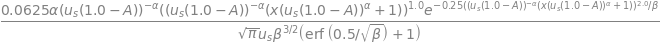

In [32]:
sp.simplify(sp.diff(S, u_s))


<!-- <div class="numbering">5/3</div> -->

## Результаты моделирования динамики детонации через реактивное уравнение Бюргерса

## Результаты с WENO5-JS и WENO5-M для уравнений Эйлера
<figure style="text-align: center; margin: 0 auto;"><img style="text-align: center; margin: 0 auto; width:50%;" src="aim_ad_astra.png" />
    <figcaption style="text-align: center; margin: 0 auto; ">Рис. 6: Языки Арнольда, полученные для уравнений Эйлера <span style="font-style: italic;">(Goldin & Kasimov. J. Fluid Mech. vol. 946. (2022) <a href="https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/synchronization-of-detonations-arnold-tongues-and-devils-staircases/7AD32F264E212A932B80DDE146B09C1A">doi:10.1017/jfm.2022.581</a>)</span></figcaption></figure>

<!-- <div class="numbering">6</div> -->

## Текущие результаты и конечные цели исследования
<figure style="text-align: center; margin: 0 auto;"><img src="zeroth_approx.png" style="text-align: center; margin: 0 auto; width: 50%;" />
    <figcaption style="text-align: center; margin: 0 auto; ">Рис. 7: 3120 точек в пространстве параметров $(\omega, A)$ гармонических условий среды, подсвеченных по грубо посчитанному числу различных максимумов $u_s$</figcaption></figure>

<!-- <div class="numbering">6/1</div> -->

Бифуркации? Хаос? Аттракторы?

<figure style="text-align: center; margin: 0 auto;"><img src="unstable_detonation_mode_locking.png" style="text-align: center; margin: 0 auto; width: 80%;" />
    <figcaption style="text-align: center; margin: 0 auto; ">Рис. 8: Неустойчивая детонация с $ \alpha=4.5 $, $ \beta=0.1 $, среда перед волной определяется $ A=0.05 $, (a) $ k=0 $, (b) $ k=0.01 $, (c) $ k = 0.1 $, (d) $ k = 0.4 $</figcaption></figure>


<!-- <div class="numbering">7</div> -->

<figure style="text-align: center; margin: 0 auto; position: ">
<!--     absolute; display: block; -->
    <img src="adv.svg" style="text-align: center; margin: 0 auto;" />
<!--     <img src="weno5fm-res_n_401.svg" style="" /> -->
<!--     <img src="weno7sm-res_n_401.svg" style="text-align: center; margin: 0 auto; width: 80%; position: absolute; top: 0; left: 0;" />
    <img src="weno7s-res_n_401.svg" style="text-align: center; margin: 0 auto; width: 80%; position: absolute; top: 0; left: 0;" /> -->
    <figcaption style="text-align: center; margin: 0 auto; ">Рис. 9: Сравнение схем на линейной задаче (4 волны классического теста Дзяня и Шу перенесены 8 раз ($t=8$))</figcaption></figure>


<!-- <div class="numbering">8</div> -->

## Градиентная катастрофа и разрывные решения
### Non-oscillatory Problems Require Essentially Non-oscillatory Solutions

In [ ]:
@nb.njit((nbt.float64[:],
          nbt.Array(nbt.int64, 1, 'A', readonly=True),
          nbt.i8, nbt.f8, nbt.optional(nbt.f8),
          nbt.optional(nbt.f8), nbt.i1,))
def weno5_lf(u: npt.NDArray[np.float64],
             int_idx: npt.NDArray[np.int64],
             ishock: np.int64,
             amp: np.float64,
             x_lab: Optional[np.float64],
             wn: Optional[np.float64],
             sign: np.int8) -> npt.NDArray[np.float64]:
    """FD Weighted essentially non-oscillatory 5-th order method (WENO-5)
    to calculate and return the intercell fluxes at right cell edges
    using the Lax-Friedrichs (LF) numerical flux splitting function.

    int_idx = Nint represents the indices of the internal points.
    Return the flux at the right cell edge: flux = F_{j+1/2}
    u = [f(j-2) f(j-1) f(j) f(j+1) f(j+2) f(j+3)]'.
    Shifted by -1, this flux gives the flux at i = 3+1/2,
    which is the first cell boundary ahead of the shock position, i=3.
    Stencil (3 substencils): [j-2, j-1, j+0, j+1, j+2, ...] for '+'
	                (or [j+3, j+2, j+1, j+0, j-1, ...]      for '-').
                    "Специальный интерполятор"
    """

    eps = 1e-40  # meant to avoid divison by zero

    u_s = u[ishock]

    # Maximum magnitude of the flux derivative F_u = (u - D)
    # with respect to the corresponding conserved quantity u
    alpha = np.absolute(u - Dshock(u_s, amp, x_lab, wn, sign)).max()
    f_minus = 0.5 * (reactive_burgers_flux(u, u_s, amp, x_lab, wn, sign)
                     - alpha * u)
    f_plus = 0.5 * (reactive_burgers_flux(u, u_s, amp, x_lab, wn, sign)
                    + alpha * u)

    flux = np.zeros_like(u)

    # promised shift by -1
    shifted_index_range = range(int_idx[0] - 1, int_idx[-1] + 1)
    # at all internal-cell edges, 3:N+3
    for j in shifted_index_range:
        u_minus = np.array([f_minus[j-2], f_minus[j-1], f_minus[j],
                            f_minus[j+1], f_minus[j+2], f_minus[j+3]],
                           dtype=np.float64)
        u_plus = np.array([f_plus[j-2], f_plus[j-1], f_plus[j],
                           f_plus[j+1], f_plus[j+2], f_plus[j+3]],
                          dtype=np.float64)

        # smoothness indicators of the stensil
        # (measure how smooth u is in the stensil)
        ISminus = np.array([
            np.dot(np.dot(u_minus, kfr.weno_matrices.WmAm0), u_minus),
            np.dot(np.dot(u_minus, kfr.weno_matrices.WmAm1), u_minus),
            np.dot(np.dot(u_minus, kfr.weno_matrices.WmAm2), u_minus)
        ])

        ISplus = np.array([
            np.dot(np.dot(u_plus, kfr.weno_matrices.WmAp0), u_plus),
            np.dot(np.dot(u_plus, kfr.weno_matrices.WmAp1), u_plus),
            np.dot(np.dot(u_plus, kfr.weno_matrices.WmAp2), u_plus)
        ])

        # the weights (with d_lin_weights being
        # the linear weights yielding (2*3-1)=5th order accuracy)
        d_lin_weights = 0.1 * np.array([1, 6, 3], dtype=np.float64)
        alphaplus = d_lin_weights / (eps + ISplus) ** 2.
        alphaminus = d_lin_weights / (eps + ISminus) ** 2.

        omegaplus = alphaplus / alphaplus.sum()
        omegaminus = alphaminus / alphaminus.sum()

        fhatplus = np.dot(omegaplus,
                          np.dot(kfr.weno_matrices.WmNplus, u_plus))
        fhatminus = np.dot(omegaminus,
                           np.dot(kfr.weno_matrices.WmNminus, u_minus))

        flux[j] = fhatplus + fhatminus

    return flux

## О MOL-FD-WENO-схемах реконструкции потока с его разбиением

<p style="text-align: justify;">"Несмотря на обширную литературу по данному направлению, вопрос расширения порядка аппроксимации схем и выбора нелинейных весов для сохранения высокого порядка аппроксимации на немонотонных участках решений является открытым."<p>

—<span style="font-style: italic;">Н. М. Евстигнеев. Компьютерные исследования и моделирование, 8:5, 721–753. (2016) <a href="http://crm.ics.org.ru/journal/article/2498/">doi:10.20537/2076-7633-2016-8-5-721-753</a></span>

Также мало изучен вопрос условия Куранта и совместной сходимости WENO5 с разными методами интегрирования по времени. Этим вопросом часто пренебрегают.



<figure style="text-align: center;"><img style="text-align: center; margin: 0 auto;" src="weno5.png" alt="WENO5 schematic analysis"/>
    <figcaption style="text-align: center; margin: 0 auto; ">Рис. 10: Схема WENO5 метода реконструкции (см. <span style="font-style: italic;">Hong, Ye & Ye. Advances in Aerodynamics 2(1). (2020) <a href="https://www.researchgate.net/publication/343379646_An_improved_WENO-Z_scheme_with_symmetry-preserving_mapping">doi:10.1186/s42774-020-00043-w</a></span>)</figcaption>
</figure>


<!-- <div class="numbering">9</div> -->

Идея конечно-разностной WENO-реконструкции состоит в подборе интерполяционного полинома высокого порядка, аппроксимирующего функцию *численного потока* $h$, такую, что в ячейке
$$ \left.\frac{df}{dx}\right|_{x=x_j} = \frac{h_{j+1/2} - h_{j-1/2}}{\Delta x}. $$
Таким образом, h определяется из уравнения
$$ f(x) = \intop_{x-\Delta x/2}^{x+\Delta x/2}h\left( \xi \right) d\xi. $$
Отсюда легко видеть, что 
$$ \left.\frac{du}{dt}\right|_{x=x_j} = - \frac{h_{j+1/2} - h_{j-1/2}}{\Delta x}. $$

Итак, $ \hat{f} \approx h $ и
$$ \left.\frac{du}{dt}\right|_{x=x_j} \approx - \frac{\hat{f}_{j+1/2} - \hat{f}_{j-1/2}}{\Delta x}. $$


<!-- <div class="numbering">9/1</div> -->

## WENO-JS и другие WENO схемы

$$ \hat{f}_{j+1/2}=\begin{cases}
\mathscr{F}\left[f_{j-(r-1)},\dots,f_{j-1},f_{j},f_{j+1},\dots,f_{j+(r-1)}\right] & \text{для }\rightarrow\text{ волн}\\
\mathscr{F}\left[f_{j+(r-1)+1},\dots,f_{j+2},f_{j+1},f_{j},\dots,f_{j-(r-1)+1}\right] & \text{для }\leftarrow\text{ волн}.
\end{cases}$$

$$ \mathscr{F}\left[f_{j-(r-1)},\dots,f_{j+(r-1)}\right] = \sum_{k=0}^{r-1} \omega_k \cdot \hat{f}_k $$

$$ \omega_n = \frac{\alpha_n}{\sum_k\alpha_k}, \text{ где } \alpha_n = \frac{\bar{\omega}^{\text{lin. ideal}}_n}{\left(\varepsilon + \beta_k\right)^p}, $$
$$ \beta_m \stackrel{\text{def}}{:=} \sum_{k=0}^{r-1} \Delta x^{2k-1}\intop_{x_{j-1/2}}^{x_{j+1/2}} \left(\frac{d^k \hat{f}_k}{dx^k}\right)^2 dx $$


<!-- <div class="numbering">10</div> -->

## WENO-M

Первое предложенное отображение, восстанавливающее порядок схем WENO-JS в критических точках (и улучшающее спектральные характеристики):
$$ g_{\text{HAP}}\colon\omega\mapsto\frac{\omega\left(\bar{\omega}_{k}^{\text{lin. ideal}}+\left(\bar{\omega}_{k}^{\text{lin. ideal}}\right)^{2}-3.\bar{\omega}_{k}^{\text{lin. ideal}}\cdot\omega+\omega^{2}\right)}{\left(\bar{\omega}_{k}^{\text{lin. ideal}}\right)^{2}+\omega\left(1.-2.\bar{\omega}_{k}^{\text{lin. ideal}}\right)},\qquad\substack{k=\overline{0,\left(r-1\right)}\\
\bar{\omega}_{k}^{\text{lin. ideal}}\in\left(0\mathop{..}1\right)
}, $$
что можно записать более осмысленно с выделением $\bar{\omega}_{k}^{\text{lin. ideal}}$, как 
$$ g_{\text{HAP}}\colon\omega\mapsto\left(\bar{\omega}_{k}^{\text{lin. ideal}}+\frac{\left(\omega-\bar{\omega}_{k}^{\text{lin. ideal}}\right)^{3}}{\left(\omega-\bar{\omega}_{k}^{\text{lin. ideal}}\right)^{2}+\omega\cdot\left(1.-\omega\right)}\right),\qquad\substack{k=\overline{0,\left(r-1\right)}\\
\bar{\omega}_{k}^{\text{lin. ideal}}\in\left(0\mathop{..}1\right)
}.
$$


<!-- <div class="numbering">11</div> -->

## WENO-FM

Недавно предложенный симметризованный (более симметричный по изначальным весам JS и более независимый от направления потока) вариант отображения:

$$ \lambda_j \stackrel{\text{def}}{:=} \frac{1/\left(\beta_j+\epsilon\right)^p}{\sum_k 1 / \left(\beta_k+\epsilon\right)^p} $$


$$ g_{\text{FM}}\colon\lambda\mapsto\frac{\lambda\left(\bar{\lambda}+\left(\bar{\lambda}\right)^{2}-3.\bar{\lambda}\cdot\lambda+\lambda^{2}\right)}{\left(\bar{\lambda}\right)^{2}+\lambda\left(1.-2.\bar{\lambda}\right)},\qquad \bar{\lambda}\stackrel{\text{def}}{:=}\frac{1}{r}\in\left(0\mathop{..}1\right). $$


<!-- <div class="numbering">12</div> -->

<figure style="text-align: center; margin: 0 auto;"><img src="weno5fm_err.svg" style="text-align: center; margin: 0 auto; width: 80%;" />
    <figcaption style="text-align: center; margin: 0 auto; ">Рис. 10: Анализ порядка аппроксимации для $u\left(x_s\right)$ с использованием eBDF5-FD-WENO5-FM c $\text{CFL}=0.16$ на простом устойчивом решении детонации с обезразмеренным реактивным уравнением Бюргерса с $u\left(x_s\right)=1.$</figcaption></figure>


<!-- <div class="numbering">13</div> -->

## WENO-S
*Wu et al. J. Comp. Phys. 432. (2021) [doi:10.1016/j.jcp.2021.110158](https://www.researchgate.net/publication/348872745_Very_high_order_WENO_schemes_using_efficient_smoothness_indicators).*

<p>Новые веса, постоянные на модах (синусоидах):</p>
$$ \delta_S \left[f\right] = x \mapsto \left(f\left(x+h/2\right)-f\left(x-h/2\right)\right) $$
$$ \sigma_S \left[f\right] = x \mapsto \left(f\left(x+h/2\right)+f\left(x-h/2\right)\right) $$
$$ a = \left.\left[\sigma_S^2 \delta_S^{r-3} f\right]\right|_{x=x_c}, \quad
    b = \left.\left[\sigma_S \delta_S^{r-2} f\right]\right|_{x=x_c}, \quad
    c = \left.\left[\delta_S^{r-1} f\right]\right|_{x=x_c} $$
$$ \beta_S\left[f\right] = b^2 + \left|ac\right| $$
$$ \left(\alpha_S\right) = \bar{\omega}^{\text{lin. ideal}} \left( 1 + \left(\frac{\tau_{2r-1(S)}}{\beta^S+\varepsilon}\right) \right) $$
$$ \tau_{2r-1(S)} = \beta_S \left[\delta^{r-1}f\right] \text{ в }x_c=x_j $$
$$ a, b, c = \sum_{подшаблон} \gamma_{r,l} f_k $$
<figure style="text-align: center; margin: 0 auto;"><img style="text-align: center; margin: 0 auto;" src="weno_s.png" />
    <figcaption style="text-align: center; margin: 0 auto;">Рис. 11: Коэффициенты $\gamma_{r,l}$ для WENO11-S</figcaption></figure>


<!-- <div class="numbering">14</div> -->

<figure style="text-align: center; margin: 0 auto;"><img src="weno7sm_err.svg" style="text-align: center; margin: 0 auto; width: 80%;" />
    <figcaption style="text-align: center; margin: 0 auto; ">Рис. 12: Анализ порядка аппроксимации для $u\left(x_s\right)$ с использованием SSP-TS-ERK(12, 8)-FD-WENO7-SM c $\text{CFL}=1.$ на простом устойчивом решении детонации с обезразмеренным реактивным уравнением Бюргерса с $u\left(x_s\right)=1.$</figcaption></figure>


<!-- <div class="numbering">15</div> -->

<figure style="text-align: center; margin: 0 auto;"><img src="weno5fm_err_limit_cycle_period_1.svg" style="text-align: center; margin: 0 auto; width: 80%;" />
    <figcaption style="text-align: center; margin: 0 auto; ">Рис. 13: Анализ формального порядка аппроксимации для $u\left(x_s\right)$ с использованием eBDF5-FD-WENO5-FM c $\text{CFL}=0.16$ на решении вида предельного цикла периода 1 ($ A=0.05 $, $ k=0.5 $)</figcaption></figure>


<!-- <div class="numbering">16</div> -->

<figure style="text-align: center; margin: 0 auto;"><img src="period_1_limit_cycle.svg" style="text-align: center; margin: 0 auto; width: 80%;" />
    <figcaption style="text-align: center; margin: 0 auto; ">Рис. 14: Решение вида предельного цикла периода 1 для $u\left(x_s\right)$ (с параметрами $ A=0.05 $, $ k=0.5 $)</figcaption></figure>


<!-- <div class="numbering">16/1</div> -->

## Выводы и перспективы

### Выводы

<ul style="text-align: justify;">
<li>WENO схемы высокого порядка с многоэтапными, многослойными методами интегрирования по времени соотвествующих порядков и глобальным расщеплением потока Лакса-Фридрихса вполне подходят для эффективного высокоточного решения реактивного уравнения Бюргерса.</li>
<li>На основе изучения литературы по теме и их сравнительного анализа предпочтение отдаётся новым схемам с симметризованными весами типа WENO-FM.</li>
<li>Для интегрирования по времени хорошо себя показывают методы по порядку не ниже простраственной реконструкции. SSP-схемы на наших задачах всё ещё не лучше с WENO, чем хорошие не SSP-схемы соотвествующих порядков, хотя и не хуже.</li>
</ul>


### Перспективы

<p style="text-align: justify;">Ещё предстоит построить высокоточную картину языков Арнольда для уравнения Бюргерса, расширить зону параметров до области пересечения языков Арнольда, изучить вид границы этой области и исследовать переход к хаотическим решениям.</p>

<!-- <div class="numbering">17</div> -->

<div style="text-align: center;">
    <h1> Спасибо за внимание! </h1>
    <h2> Ответы на вопросы </h2>
    <img src="spectrogram-gonchar.png" style="text-align: center; margin: 0 auto; width: 40%;" />
</div>
<!-- 
<img src="link_qr.png" height=140 width=140 style="float: left; padding: 5px; margin-left: 100px;" /> -->

<!-- 
 ### Контакты
 
* E-mail: fedor1113-public@yandex.com
* Element (бывший Riot.im): fedor1113
* Я также есть на *ResearchGate*.


<div style="text-align: center;"><img src="tumbleweed.jpg"></div> -->

<!-- <div class="numbering">18</div> -->